# Lab 9 - Graph Data Analytics

Complete the code with TODO tag.

If you haven't installed networkx package, you can run the following command (note the exclamation mark)

```bash
!conda install networkx --yes
```

## 1. Centrality Analysis
In this exercise, you will implement the pagerank centrality.

Graph named 'Zachary's Karate Club' with 34 nodes and 78 edges


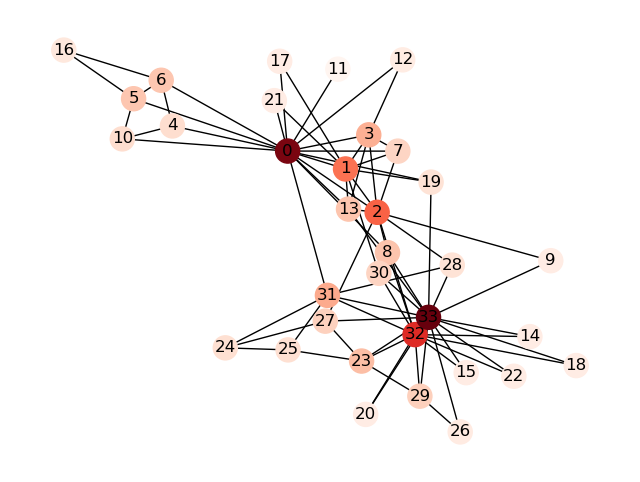

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def pagerank_centrality(G, iter=100, damping=0.85):
    p = np.array([1 / len(G) for _ in G.nodes()])
    for _ in range(iter):
        new_p = np.zeros(len(G))
        for node in G.nodes():
            for neighbor in G[node]:
                new_p[neighbor] += damping * (p[node] / len(G[node]))
        new_p += (1 - damping) * (p.sum() / len(G))  # Account for dangling nodes uniformly
        new_p /= new_p.sum()  # Normalize to prevent overflow
        p = new_p
    return p

G = nx.karate_club_graph()
print(f"Graph named 'Zachary's Karate Club' with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

values = pagerank_centrality(G)
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes instance
nx.draw(G, ax=ax, cmap=plt.get_cmap('Reds'), node_color=values, with_labels=True)
plt.show()


## 2. Community Analysis

### 2.1. Clique Percolation Method

One well-known algorithm for detecting overlapping communities is called the Clique Percolation Method (CPM).

In [5]:
from itertools import combinations

def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    
    # TODO: find cliques of the graph
    cliques = list(frozenset(c) for c in nx.find_cliques(G) if len(c) >= k)
    perc_graph.add_nodes_from(cliques)
    
    # TODO: Add an edge in the clique graph for each pair of cliques that percolate
    for c1, c2 in combinations(cliques, 2):
        if len(c1.intersection(c2)) >= (k-1):
            perc_graph.add_edge(c1, c2)
    
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))


Test with a small dataset

Graph with 34 nodes and 78 edges
---0.00 seconds---


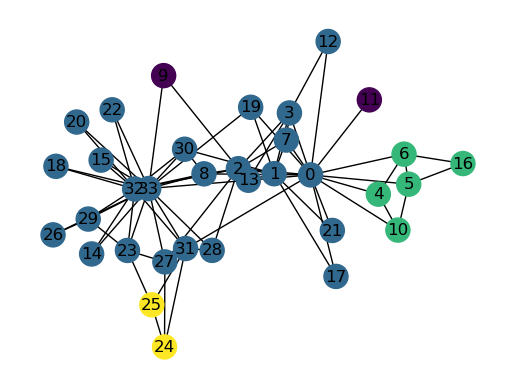

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

def partition(communities):
    node2communities = dict()
    for counter, c in enumerate(communities):
        for node in c:
            if node not in node2communities:
                node2communities[node] = []
            node2communities[node] += [counter]
    return node2communities

# Instead of nx.info(G), manually print details
G = nx.karate_club_graph()
print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

start_time = time.time()
communities = get_percolated_cliques(G, 3)
print(f"---{time.time() - start_time:.2f} seconds---")

part = partition(communities)
values = [part.get(node, [-1])[0] for node in G.nodes()]

# Explicitly create a figure and axes
fig, ax = plt.subplots()
nx.draw(G, ax=ax, node_color=values, with_labels=True)
plt.show()


### 2.2. Efficient Implementation
That implementation is correct but expensive---it requires O(N^2) clique comparisons, where N is the number of cliques (which is often much larger than the number of nodes!).  If we use a python dictionary to index which nodes belong to which cliques, then we can easily compare only those cliques that share at least one node in common.  This implementation is a bit longer but should be more efficient:

---0.01 seconds---
Graph with 34 nodes and 78 edges


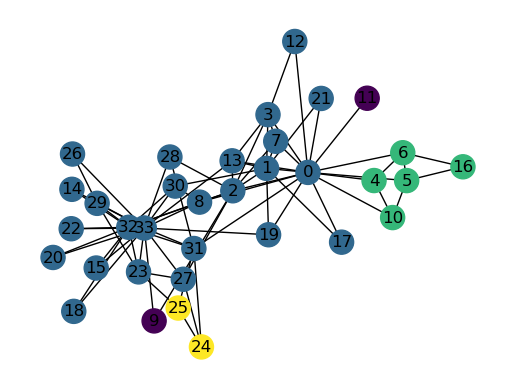

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
from collections import defaultdict

def get_percolated_cliques2(G, k):
    perc_graph = nx.Graph()
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)

    # Index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # Check adjacency between cliques based on shared nodes
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Yield connected components of the percolated clique graph
    for component in nx.connected_components(perc_graph):
        yield frozenset.union(*component)

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if adj_clique != clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

def partition(communities):
    node2communities = dict()
    for counter, c in enumerate(communities):
        for node in c:
            if node not in node2communities:
                node2communities[node] = []
            node2communities[node].append(counter)
    return node2communities

# Setup and compute percolated cliques
G = nx.karate_club_graph()
start_time = time.time()
communities = list(get_percolated_cliques2(G, 3))
print(f"---{time.time() - start_time:.2f} seconds---")
part = partition(communities)
values = [part.get(node, [-1])[0] for node in G.nodes()]

# Manually print graph details instead of using nx.info(G)
print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Explicitly create a figure and axes for drawing
fig, ax = plt.subplots()
nx.draw(G, ax=ax, node_color=values, with_labels=True)
plt.show()


### 2.3. Test with large dataset

Now we test with a real large-scale network data at https://snap.stanford.edu/data/com-Amazon.html

In [16]:
import networkx as nx
import time

# Load graph from edgelist file
G = nx.read_edgelist("email-Eu-coure.txt")
# G = nx.read_edgelist("com-amazon.ungraph.txt")  # Uncomment to use another dataset

# Display graph information
print(f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Timing and executing first community detection
start_time = time.time()
communities = get_percolated_cliques(G, 3)
print(f"Time for get_percolated_cliques: {time.time() - start_time:.2f} seconds")

# Timing and executing second community detection
start_time = time.time()
communities = get_percolated_cliques2(G, 3)
print(f"Time for get_percolated_cliques2: {time.time() - start_time:.2f} seconds")


Graph with 1005 nodes and 16706 edges
Time for get_percolated_cliques: 0.00 seconds
Time for get_percolated_cliques2: 0.00 seconds
